<a href="https://colab.research.google.com/github/krissivolga29-commits/analytics_big_data/blob/main/%C2%AB%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8_%D0%B4%D0%B5%D1%82%D0%B5%D0%BA%D1%86%D0%B8%D1%8F_%D0%BE%D0%B1%D1%8A%D0%B5%D0%BA%D1%82%D0%BE%D0%B2%C2%BB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# «Сегментация и детекция объектов»


#Распознавание рукописного ввода на примере базы MNIST

Построить классификатор изображений рукописного ввода на базе MNIST. В качестве шаблона в данной работе можно использовать ipython-ноутбук 002-digit.ipynb.

Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.

В качестве модели классификатора можно использовать любую известную Вам модель, за исключением сверточных нейронных сетей.

Критерием качества классификатора является метрика accuracy. Для получения зачета по данной работе, значение метрики accuracy должно быть больше 0.6. Метрика оценивается на тестовой выборке в рамках контеста Digit Recognizer на Kaggle.

Решение необходимо предоставить в виде ipython-ноутбука с реализацией процесса построения модели и скриншота с финальным результатом на Kaggle.

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC

# Загружаем исходные данные

In [ ]:
train = np.loadtxt('/content/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('/content/test.csv', delimiter=',', skiprows=1)

In [ ]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [ ]:
train.shape, train_label.shape, test.shape

((42000, 785), (42000,), (28000, 784))

Визуализируем исходные данные

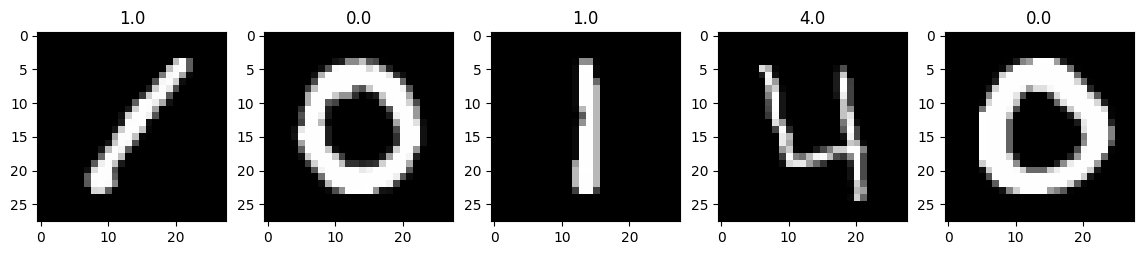

In [ ]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

# Обучение модели на основе гистограммы градиентов (HOG)

Вычисляем X и Y составляющие градиента с помощью оператора Собеля.

In [ ]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

Вычисляем угол и длину вектора градиента.

In [ ]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

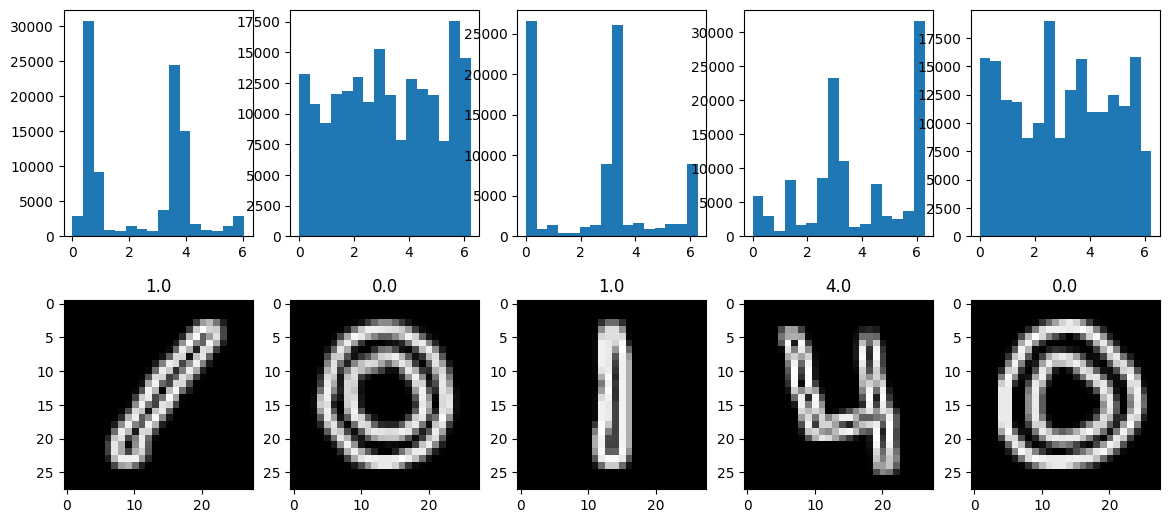

In [ ]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

Вычисляем гистограммы градиентов с учетом длины вектора градиента.

In [ ]:
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

Нормируем вектор гистограммы.

In [ ]:
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

Обучение модели на основе train данных.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_hist, train_label, test_size=0.2, random_state=21)

В качестве модели классификатора будем использовать Метод опорных векторов SVM.

In [ ]:
model = SVC(random_state=21)
model.fit(X_train, y_train)
pred = model.predict(X_val)

In [ ]:
report = classification_report(y_val, pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.45      0.46      0.46       814
         1.0       0.97      0.95      0.96       893
         2.0       0.54      0.51      0.52       796
         3.0       0.63      0.72      0.67       828
         4.0       0.71      0.73      0.72       829
         5.0       0.68      0.66      0.67       806
         6.0       0.51      0.46      0.49       888
         7.0       0.85      0.79      0.82       886
         8.0       0.57      0.61      0.59       803
         9.0       0.67      0.68      0.68       857

    accuracy                           0.66      8400
   macro avg       0.66      0.66      0.66      8400
weighted avg       0.66      0.66      0.66      8400



Предсказание метки на основе test данных.

In [ ]:
pred_test = model.predict(test_hist)

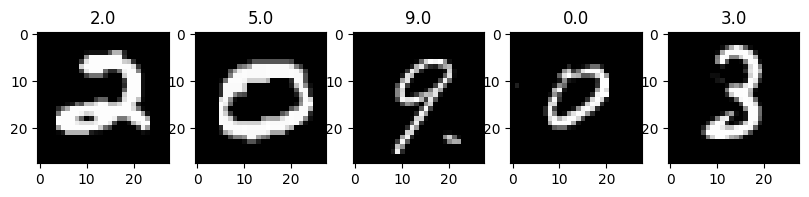

In [ ]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(2, 10, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

Вывод: Для классификатора построенного на признаках, полученных в результате предобработки изображений с помощью гистограммы градиентов(HOG) была полученна accuracy 0.66. Для test данных была построена визуализация с полученными метками.

# Обучение модели на основе результата PCA преобразования.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train[:, 1:], train_label, test_size=0.2, random_state=21)

In [ ]:
cov_matrix = np.matmul(X_train.T, X_train)
cov_matrix.shape

(784, 784)

In [ ]:
U, S, _ = np.linalg.svd(cov_matrix)
S_cumsum = np.cumsum(S) / np.sum(S)

Text(0.5, 1.0, 'График совокупной дисперсии')

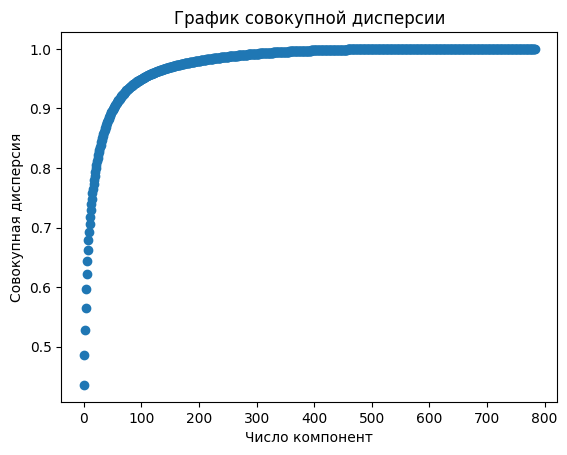

In [ ]:
plt.plot(S_cumsum, 'o')
plt.xlabel('Число компонент')
plt.ylabel('Совокупная дисперсия')
plt.title('График совокупной дисперсии')

Проверим порог для накопленной суммы собственных значений для диапазона 0,85 до 0,9. И подберём оптимальный

In [ ]:
S_thr = 0.87
n_comp = np.argmax(np.where(S_cumsum > S_thr, 1, 0))
print('n_comp=%d S=%.3f' % (n_comp, S_cumsum[n_comp]))

n_comp=39 S=0.872


Оптимальным оказался порог 0.87 при n_comp=39.

Обучим модель, используя PCA преобразование для полученного числа компонент.

In [ ]:
model_rfc = make_pipeline(PCA(n_components=39,
                              copy = True,
                              whiten = False,
                              svd_solver = 'auto',
                              tol = 0.0,
                              iterated_power = 'auto',
                              random_state = 21),
                          StandardScaler(),
                          SVC(random_state=21))
model_rfc.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=39, random_state=21)),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=21))])

In [ ]:
pred = model_rfc.predict(X_val)
report = classification_report(y_val, pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       814
         1.0       0.99      0.98      0.99       893
         2.0       0.97      0.98      0.98       796
         3.0       0.98      0.97      0.98       828
         4.0       0.98      0.98      0.98       829
         5.0       0.98      0.98      0.98       806
         6.0       0.98      0.99      0.99       888
         7.0       0.98      0.98      0.98       886
         8.0       0.97      0.98      0.97       803
         9.0       0.98      0.97      0.97       857

    accuracy                           0.98      8400
   macro avg       0.98      0.98      0.98      8400
weighted avg       0.98      0.98      0.98      8400



In [ ]:
print(accuracy_score(y_val, pred))

0.9807142857142858


In [ ]:
pred_test = model_rfc.predict(test)

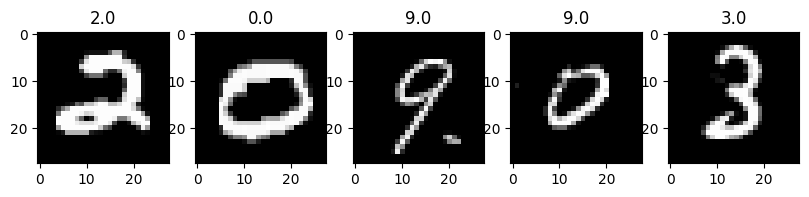

In [ ]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(2, 10, i)
    plt.imshow(img, cmap='gray')
    subplot.set_title('%s' % pred_test[i - 1])

Вывод: Для классификатора построенного на признаках, полученных на результате PCA преобразования, была полученна accuracy 0.98. Для test данных была построена визуализация с полученными метками.

# Готовим файл для отправки

In [ ]:
with open('submit.csv', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write(f'{i},{int(p)}\n')

In [ ]:
submit = pd.read_csv('submit.csv')
submit.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
